In [17]:
from functools import lru_cache
import scipy
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu
import itertools
import sys
sys.path.insert(0, "../../lib") 
import latexify

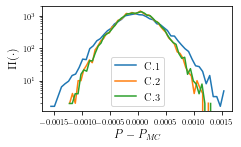

In [35]:
def load_obj(kin,kind):
    directory='kin_'+str(kin)
    name=  kind +'.pkl'
    with open(directory+'/data/dic-' + name , 'rb') as f:
        return pickle.load(f)
def load_and_hist(kin,kind):
    dic = load_obj(kin,kind)    
    P_t_C1 = dic['P_t_C1']
    P_t_C2 = dic['P_t_C2']
    P_t_C3 = dic['P_t_C3']
    P_t_MC = dic['P_t_MC']
    J = dic['J']
    T = dic['T']
    latexify.latexify(columns = 2)
    h,b  = np.histogram(P_t_C1-P_t_MC,50,density=True)
    plt.plot(b[:-1],h,label = 'C.1')
    h,b  = np.histogram(P_t_C2-P_t_MC,50,density= True)
    plt.plot(b[:-1],h,label = 'C.2')
    h,b  = np.histogram(P_t_C3-P_t_MC,50,density= True)
    plt.plot(b[:-1],h,label = 'C.3')
    plt.semilogy()
    plt.legend(fontsize = 10.5)
    plt.xlabel('$P-P_{MC}$',fontsize = 12)
    plt.ylabel('$\Pi(\cdot)$',fontsize = 12)
    
kin = 3
kind = 'asymmetric'
load_and_hist(kin,kind)
#plt.title(kind)
plt.tight_layout()
#plt.savefig('different_OTA_'+kind+'.pdf')

In [16]:

def make_network(N,k):
    '''generate a fat tailed network'''
    #sequence =  generate_degree_seq(gamma,N)
    sequence = np.ones(N,dtype=int)*k
    if np.sum(sequence)%2==1:
        sequence[-1]=sequence[-1]+1
    #make oriented network
    G = nx.generators.degree_seq.configuration_model(sequence)
    G.remove_edges_from(nx.selfloop_edges(G))
    J = nx.adjacency_matrix(G)
    row = J.tocoo().row
    col = J.tocoo().col
    cond = row>col
    interaction = np.where(np.random.rand(np.count_nonzero(cond))>.5,1.,-1.)
    A = scipy.sparse.coo_matrix((interaction,(row[cond],col[cond])),shape = (N,N))
    J = (A+A.T).tocsc()
    return J
def antisymmetric_sign(J):
    row = J.tocoo().row
    col = J.tocoo().col
    cond = row>col
    interaction = np.where(np.random.rand(np.count_nonzero(cond))>.5,1,-1).astype(np.float32)
    A = scipy.sparse.coo_matrix((interaction,(row[cond],col[cond])),shape = (N,N))
    J = (A-A.T).tocsc()
    return J

def make_epsilon(J):
    N = J.shape[0]
    row = J.tocoo().row
    col = J.tocoo().col
    bi_link = set(zip(row,col))&set(zip(col,row))#set of bidirectional link
    if len(bi_link)==0:
        return scipy.sparse.coo_matrix((N,N))
    a,b = zip(*bi_link)
    return scipy.sparse.coo_matrix((np.ones(len(a),dtype=bool),(np.array(a),np.array(b))),shape = (N,N)).tocsc()

def cavity(P,inter,T,theta):
    @lru_cache(maxsize=None)
    def recursion(bias, l):
        if (l == K):
            bias = (bias + theta) #/ np.sqrt(avg_degree)
            return np.tanh(bias / 2 / T)

        include = P[l] * recursion(bias + inter[l], l + 1)  # include node l with prob. P[j[l]]
        exclude = (1 - P[l]) * recursion(bias, l + 1)  # ignore node l
        return include + exclude
    bias = 0
    K = len(inter)
    P_new = 0.5 + 0.5 * recursion(bias, 0)
    recursion.cache_clear()
    return P_new


In [17]:
N = 10000
k = 3
T = 1
J = make_network(N,k)
J = antisymmetric_sign(J)

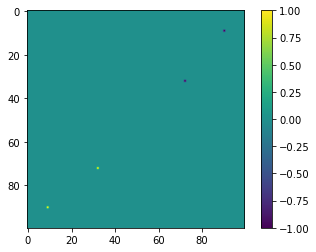

In [18]:
plt.imshow(J.toarray()[:100,:100])
plt.colorbar()

Zhang expression

In [4]:
def cavity_iteration(J,T,max_iter = 10,precision = 1e-4):
    def probability_upd(i,cond,theta,P_t_2,P_A,P_B):
        cav_neigh = np.array(js[i])[cond]

        A = cavity(P_A[cav_neigh,i].toarray(),inter = np.array(interaction[i])[cond],T = T,theta=theta)
        P_B_temp = np.where(epsilon[cav_neigh,i].toarray(),P_B[cav_neigh,i].toarray(),P_A[cav_neigh,i].toarray())
        #selects either P_A[j,i] or P_B[j,i] depending on epsilon[j,i]=1
        B = cavity(P_B_temp,inter = np.array(interaction[i])[cond],T = T,theta=theta)
        return (1-P_t_2[i])*A+P_t_2[i]*B
    J_transpose = J.transpose()


    #create network properties
    epsilon = make_epsilon(J)
    js = J_transpose.tolil().rows
    interaction = J_transpose.tolil().data
    #R = epsilon.multiply(J_transpose)
    row = J.tocoo().row#link to 
    col = J.tocoo().col#link from
    #data= J_transpose.tocoo().data#interaction strenght from col to row
    Ks = np.array([len(neigh) for neigh in js])  # in degree of each gene
    avg_degree = np.mean(Ks)

    print('fraction of symmetric links over total:\n',len(epsilon.data)/len(J.data))

    trj = [] 
    P_A =J.copy()
    P_B= J.copy()
    P_A.data =np.ones(J.nnz)#np.random.rand(J.nnz)#prob of node activation
    P_B.data =np.ones(J.nnz)#np.random.rand(J.nnz)
    P_t_1 = np.random.rand(J.shape[0])#P^{t-1}
    P_t_2 = np.random.rand(J.shape[0])#P^{t-2}
    P_t = np.zeros(J.shape[0])
    P_A_new = P_A.copy()
    P_B_new = P_B.copy()
    #print(len(list(zip(row,col))))
    for t in range(max_iter):
        # here it is a time step of marginal and cavity
        for i in range(J.shape[0]):
            cond = np.array([True]*len(js[i]))#this is for non-cavity probabilities, predecessors. of i 
            P_t[i] = probability_upd(i,cond,0,P_t_2,P_A,P_B)

        for i,l in zip(row,col):

            cond = (np.array(js[i])!=l)#this is for cavity probabilities,# predecessors. of i /{l}
            P_A_new[i,l] = probability_upd(i,cond,0,P_t_2,P_A,P_B)
            theta = J[l,i]*epsilon[i,l]
            P_B_new[i,l] = probability_upd(i,cond,theta,P_t_2,P_A,P_B)# even if P_B depends on P_A, the index we care about different entries
            
        P_t_2 = P_t_1.copy()#progress time
        P_t_1 = P_t.copy()
        P_A = P_A_new.copy()
        P_B = P_B_new.copy()
        improvement = abs(P_t-P_t_2).max()
        if improvement<precision:
            print('ending after ',t,' iterations')
            break

    return P_A,P_B,P_t
%time P_A,P_B,P_t_zhang = cavity_iteration(J,T,150)

fraction of symmetric links over total:
 1.0
ending after  15  iterations
CPU times: user 17min 20s, sys: 470 ms, total: 17min 21s
Wall time: 17min 21s


Aurell

In [5]:
def cavity_aurell(J,T,max_iter = 10,precision = 1e-4):
    def probability_upd(i,cond,theta,P_t_2,P_A,P_B):
        cav_neigh = np.array(js[i])[cond]

        A = cavity(P_A[cav_neigh,i].toarray(),inter = np.array(interaction[i])[cond],T = T,theta=theta)
        P_B_temp = np.where(epsilon[cav_neigh,i].toarray(),P_B[cav_neigh,i].toarray(),P_A[cav_neigh,i].toarray())
        #selects either P_A[j,i] or P_B[j,i] depending on epsilon[j,i]=1
        B = cavity(P_B_temp,inter = np.array(interaction[i])[cond],T = T,theta=theta)
        return (1-P_t_2)*A+P_t_2*B
    J_transpose = J.transpose()


    #create network properties
    epsilon = make_epsilon(J)
    js = J_transpose.tolil().rows
    interaction = J_transpose.tolil().data
    #R = epsilon.multiply(J_transpose)
    row = J.tocoo().row#link to 
    col = J.tocoo().col#link from
    #data= J_transpose.tocoo().data#interaction strenght from col to row
    Ks = np.array([len(neigh) for neigh in js])  # in degree of each gene
    avg_degree = np.mean(Ks)

    print('fraction of symmetric links over total:\n',len(epsilon.data)/len(J.data))

    trj = [] 
    P_A =J.copy()
    P_B= J.copy()
    P_A.data =np.ones(J.nnz)#np.random.rand(J.nnz)#prob of node activation
    P_B.data =np.ones(J.nnz)#np.random.rand(J.nnz)
    P_t_1 = np.random.rand(J.shape[0])#P^{t-1}
    P_t_2 = np.random.rand(J.shape[0])#P^{t-2}
    P_t = np.zeros(J.shape[0])
    P_A_new = P_A.copy()
    P_B_new = P_B.copy()
    #print(len(list(zip(row,col))))
    for t in range(max_iter):
        # here it is a time step of marginal and cavity
        for i in range(J.shape[0]):
            cond = np.array([True]*len(js[i]))#this is for non-cavity probabilities, predecessors. of i 
            P_t[i] = probability_upd(i,cond,0,P_t_2[i],P_A,P_B)

        for i,l in zip(row,col):

            cond = (np.array(js[i])!=l)#this is for cavity probabilities,# predecessors. of i /{l}
            P_A_new[i,l] = probability_upd(i,cond,0,P_A[i,l],P_A,P_B)
            theta = J[l,i]*epsilon[i,l]
            P_B_new[i,l] = probability_upd(i,cond,theta,P_B[i,l],P_A,P_B)# even if P_B depends on P_A, the index we care about different entries
            
        P_t_2 = P_t_1.copy()#progress time
        P_t_1 = P_t.copy()
        P_A = P_A_new.copy()
        P_B = P_B_new.copy()      
        improvement = abs(P_t-P_t_2).max()
        if improvement<precision:
            print('ending after ',t,' iterations')
            break
    return P_A,P_B,P_t

In [6]:
%time P_A,P_B,P_t_aurel = cavity_aurell(J,T,150)

fraction of symmetric links over total:
 1.0
ending after  10  iterations
CPU times: user 12min 36s, sys: 308 ms, total: 12min 36s
Wall time: 12min 36s


In [7]:
def cavity_averaged(J,T,max_iter = 10,precision = 1e-4):
    def probability_upd(i,cond,theta,P_t_2,P_A,P_B):
        cav_neigh = np.array(js[i])[cond]

        A = cavity(P_A[cav_neigh,i].toarray(),inter = np.array(interaction[i])[cond],T = T,theta=theta)
        P_B_temp = np.where(epsilon[cav_neigh,i].toarray(),P_B[cav_neigh,i].toarray(),P_A[cav_neigh,i].toarray())
        #selects either P_A[j,i] or P_B[j,i] depending on epsilon[j,i]=1
        B = cavity(P_B_temp,inter = np.array(interaction[i])[cond],T = T,theta=theta)
        return (1-P_t_2)*A+P_t_2*B
    J_transpose = J.transpose()


    #create network properties
    epsilon = make_epsilon(J)
    js = J_transpose.tolil().rows
    interaction = J_transpose.tolil().data
    #R = epsilon.multiply(J_transpose)
    row = J.tocoo().row#link to 
    col = J.tocoo().col#link from
    #data= J_transpose.tocoo().data#interaction strenght from col to row
    Ks = np.array([len(neigh) for neigh in js])  # in degree of each gene
    avg_degree = np.mean(Ks)

    print('fraction of symmetric links over total:\n',len(epsilon.data)/len(J.data))

    trj = [] 
    P_A_2 =J.copy()
    P_B_2= J.copy()
    P_A_2.data =np.ones(J.nnz)#np.random.rand(J.nnz)#prob of node activation
    P_B_2.data =np.ones(J.nnz)#np.random.rand(J.nnz)
    P_A_1 =J.copy()
    P_B_1= J.copy()
    P_A_1.data =np.ones(J.nnz)#np.random.rand(J.nnz)#prob of node activation
    P_B_1.data =np.ones(J.nnz)#np.random.rand(J.nnz)
    P_t_1 = np.random.rand(J.shape[0])#P^{t-1}
    P_t_2 = np.random.rand(J.shape[0])#P^{t-2}
    P_t_3 = np.random.rand(J.shape[0])#P^{t-3}
    P_t = np.zeros(J.shape[0])
    P_A = P_A_1.copy()
    P_B = P_B_1.copy()
    #print(len(list(zip(row,col))))
    for t in range(max_iter):
        # here it is a time step of marginal and cavity
        for i in range(J.shape[0]):
            cond = np.array([True]*len(js[i]))#this is for non-cavity probabilities, predecessors. of i 
            P_t[i] = probability_upd(i,cond,0,P_t_2[i],P_A_1,P_B_1)

        for i,l in zip(row,col):
            P_t_2_cav = P_A_2[i,l]*(1-P_t_3[l])+P_B_2[i,l]*P_t_3[l]
            cond = (np.array(js[i])!=l)#this is for cavity probabilities,# predecessors. of i /{l}
            P_A[i,l] = probability_upd(i,cond,0,P_t_2_cav,P_A_1,P_B_1)
            theta = J[l,i]*epsilon[i,l]
            P_B[i,l] = probability_upd(i,cond,theta,P_t_2_cav,P_A_1,P_B_1)# even if P_B depends on P_A, the index we care about different entries
            
        P_t_3 = P_t_2.copy()#progress time
        P_t_2 = P_t_1.copy()#progress time
        P_t_1 = P_t.copy()
        P_A_2 = P_A_1.copy()
        P_B_2 = P_B_1.copy()        
        P_A_1 = P_A.copy()
        P_B_1 = P_B.copy() 
        improvement = abs(P_t-P_t_2).max()
        if improvement<precision:
            print('ending after ',t,' iterations')
            break
    return P_A,P_B,P_t
%time P_A,P_B,P_t_averaged = cavity_averaged(J,T,150)

fraction of symmetric links over total:
 1.0
ending after  15  iterations
CPU times: user 18min 19s, sys: 56 ms, total: 18min 19s
Wall time: 18min 19s


In [8]:
def replics_gpu(J, P_init, T, N_replics,N_iterations):

    def dynamics_gpu(J, n, T,N_iterations):
        if not (type(J) is csr_gpu):
            print('Coupling matrix should be of type'+str(csr_gpu)+', I try to convert')
            J = csr_gpu(J)
        #local_state = cp.random.seed(seed)
        N1 = J.shape[0]
        N_therm = 100
        t = 0
        while t < N_therm:
            z = cp.random.logistic(0, T , (1, N1))
            # z=numpy.random.normal(0,2*T,(1,N1))
            a = n * J - z
            n = cp.where(a > 0, 1, 0.)[0]
            t += 1
        t = 0
        #N_iterati%load_ext line_profilerons =max(int(np.log(1-alpha)/np.log(0.5*(1+np.tanh(1/2/T)))),1000)# number iterations grows at low temperature. See notes
        m = cp.zeros(N1)
        while t < N_iterations:
            z = cp.random.logistic(0, T , (1, N1),dtype=cp.float32)
            # z=numpy.random.normal(0,2*T,(1,N1))
            a = n * J - z
            n = cp.where(a > 0, 1, 0.)[0]
            m += n
            t += 1

        return m / t


    N = J.shape[0]
    initial_states = cp.where(cp.random.rand(N_replics,N,dtype=cp.float32) > P_init, 1, 0)
    P_sim = itertools.starmap(dynamics_gpu, itertools.product([J], initial_states, [T], [N_iterations]))
    #P_sim = cp.mean(cp.asarray(list(P_sim)), axis=0)
    return cp.asnumpy(cp.asarray(list(P_sim)))



In [9]:
N_replics = 50
N_iterations = 1e5
%time a = replics_gpu(csr_gpu(J), cp.random.rand(J.shape[0]), T, N_replics,N_iterations)
P_t_MC = np.mean(a,axis = 0)

CPU times: user 30min 36s, sys: 380 ms, total: 30min 36s
Wall time: 30min 36s


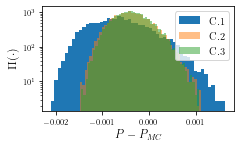

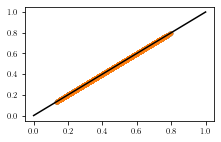

In [13]:
latexify.latexify(columns = 2)
h,b  = np.histogram(P_t_aurel-P_t_MC,50,density=True)
plt.plot(b[:-1],h,label = 'C.1')
h,b  = np.histogram(P_t_zhang-P_t_MC,50,alpha = 0.5,density= True)
plt.plot(b[:-1],h,label = 'C.2')
_ = plt.hist(P_t_averaged-P_t_MC,50,alpha = 0.5,label = 'C.3',density= True)
plt.semilogy()
plt.legend(fontsize = 10.5)
plt.xlabel('$P-P_{MC}$',fontsize = 12)
plt.ylabel('$\Pi(\cdot)$',fontsize = 12)
plt.tight_layout()
#plt.savefig('different_OTA_antisymmetric.pdf')
plt.figure()
plt.plot(P_t_aurel,P_t_MC,'.')
plt.plot(P_t_zhang,P_t_MC,'.')
plt.plot([0,1],[0,1],c = 'k')


In [10]:
def equilibrium_prob(J,T,N_iterations = 50):
    '''
    Input should be a sparse matrix  '''
    J = scipy.sparse.csc_matrix(J)
    def update_equilibrium(P,inter,T):
        numerator = np.prod(1+P*(np.exp(inter/T)-1))#boltzman factor
        return numerator/(numerator+1)#to ensure normalisation
    J_transpose = J.transpose()
    js = J_transpose.tolil().rows
    interaction = J_transpose.tolil().data
    N = J.shape[0]
    P_A =J.copy()
    P_A.data =np.random.rand(J.nnz)#prob of node activation
    row = J.tocoo().row#link to 
    col = J.tocoo().col#link from

    for t in range(N_iterations):
        P_old = P_A.copy()
        for i,l in zip(row,col):
            cond = (np.array(js[i])!=l)#this is for cavity probabilities,# predecessors. of i /{l}
            cav_neigh = np.array(js[i])[cond]   
            P_A[i,l] = update_equilibrium(P_A[cav_neigh,i].toarray().squeeze(),inter = np.array(interaction[i])[cond],T = T)
        improvement = abs(P_A-P_old).max()
        if improvement<1e-4:
            print('ending after ',t,' iterations')
            break
    P_eq = np.zeros(N)
    for i in range(N):
        cond = np.array([True]*len(js[i]))
        cav_neigh = np.array(js[i])[cond]   
        P_eq[i] = update_equilibrium(P_A[cav_neigh,i].toarray().squeeze(),inter = np.array(interaction[i])[cond],T = T)
    return P_eq
P_eq = equilibrium_prob(J,T,N_iterations = 50)

ending after  6  iterations


error committed compared to simulation

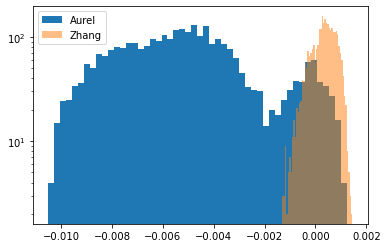

In [11]:
_ = plt.hist(P_t_aurel-P_eq,50,label = 'Aurel')
_ = plt.hist(P_t_zhang-P_eq,50,alpha = 0.5,label = 'Zhang')
plt.semilogy()
plt.legend()


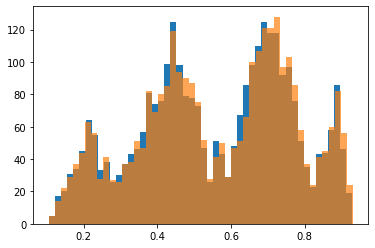

In [14]:
_ = plt.hist(P_t_aurel,50)
_ = plt.hist(P_t_zhang,50,alpha = 0.7)

In [4]:

def make_network(N,k,kind):
    '''generate a random regular network'''
    #sequence =  generate_degree_seq(gamma,N)
    sequence = np.ones(N,dtype=int)*k
    if np.sum(sequence)%2==1:
        sequence[-1]=sequence[-1]+1
    #make oriented network
    G = nx.generators.degree_seq.configuration_model(sequence)
    G.remove_edges_from(nx.selfloop_edges(G))
    J = nx.adjacency_matrix(G)
    row = J.tocoo().row
    col = J.tocoo().col
    cond = row>col
    interaction = np.where(np.random.rand(np.count_nonzero(cond))>.5,1.,-1.)
    A = scipy.sparse.csr_matrix((interaction,(row[cond],col[cond])),shape = (N,N))
    return assign_bidirectional_symmetry(A.tolil(),kind)
def antisymmetric_sign(J):
    row = J.tocoo().row
    col = J.tocoo().col
    cond = row>col
    interaction = np.where(np.random.rand(np.count_nonzero(cond))>.5,1,-1).astype(np.float32)
    A = scipy.sparse.coo_matrix((interaction,(row[cond],col[cond])),shape = (N,N))
    J = (A-A.T).tocsc()
    return J
def assign_bidirectional_symmetry(J,kind):
    '''
    return interaction matrix with chosed symmetry of interaction sign'''
    triang = scipy.sparse.tril(J)
    a,b = triang.nonzero()
    if kind == 'symmetric':
        J[b,a] = J[a,b]
    elif kind == 'antisymmetric':
        J[b,a] = -J[a,b]
    elif kind == 'asymmetric':
        J[b,a] = np.where(np.random.rand(len(b))>0.5,1,-1)
    else:
        raise ValueError("kind should be one of those: asymmetric, antisymmetric  symmetric. Instead you select: "+ kind)
    J=J
    return J    

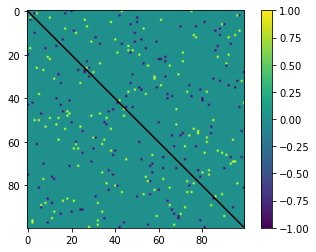

In [7]:
import networkx as nx
N = 100
k = 3
kind = 'asymmetric'
#plt.imshow(scipy.sparse.tril(make_network(N,k,kind)).toarray())
J = make_network(N,k,kind)
plt.imshow(J.toarray())
plt.colorbar()
plt.plot([N-1,0],[N-1,0],'k-')


In [13]:
import simulation
P_init = cp.random.rand(N)
N_replics = 2
T = 1
N_iterations = 100
simulation.replics_gpu(J, P_init, T, N_replics,N_iterations).mean(axis = 0).shape

(100,)